In [96]:
# Predicting Patient Test Outcomes and Analyzing Healthcare Trends

## Goals:
# Predict patient test outcomes using classification models.
# Identify key factors influencing test results (e.g., age, medical condition, insurance).
# Analyze cost trends (billing, length of stay) by test results and patient profiles.
# Provide insights for hospital resource allocation and planning.


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("health_dataset.csv")  # Assuming tab-separated based on column string

# Preview data
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,1/31/2024,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2/2/2024,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,8/20/2019,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,8/26/2019,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,9/22/2022,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,10/7/2022,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,11/18/2020,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,12/18/2020,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,9/19/2022,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,10/9/2022,Penicillin,Abnormal


In [98]:
# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Convert dates
df['Date_of_Admission'] = pd.to_datetime(df['Date_of_Admission'], errors='coerce')
df['Discharge_Date'] = pd.to_datetime(df['Discharge_Date'], errors='coerce')

# Calculate length of stay
df['Length_of_Stay'] = (df['Discharge_Date'] - df['Date_of_Admission']).dt.days

# Drop non-predictive columns
df_model = df.drop(columns=['Name', 'Doctor', 'Hospital', 'Date_of_Admission', 'Discharge_Date', 'Room_Number'])

# Encode categorical variables
df_model = pd.get_dummies(df_model, drop_first=True)

# Check for target column
target_col = [col for col in df_model.columns if 'Test' in col and 'Result' in col]
if target_col:
    df_model = df_model.dropna(subset=target_col)
    df_model[target_col[0]] = df_model[target_col[0]].astype('category').cat.codes
else:
    raise KeyError("Target column 'Test_Results' not found. Check column names.")

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split data
# Use the first column in target_col as the target variable
X = df_model.drop(columns=target_col)
y = df_model[target_col[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
# Train models
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Report": classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    }
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  \
Dummy                0.669261   
Logistic Regression  0.669261   
Decision Tree        0.668396   
Random Forest        0.701477   

                                                                Report  
Dummy                {'0': {'precision': 0.6692612612612613, 'recal...  
Logistic Regression  {'0': {'precision': 0.6692612612612613, 'recal...  
Decision Tree        {'0': {'precision': 0.6691946551101481, 'recal...  
Random Forest        {'0': {'precision': 0.7030312598673824, 'recal...  


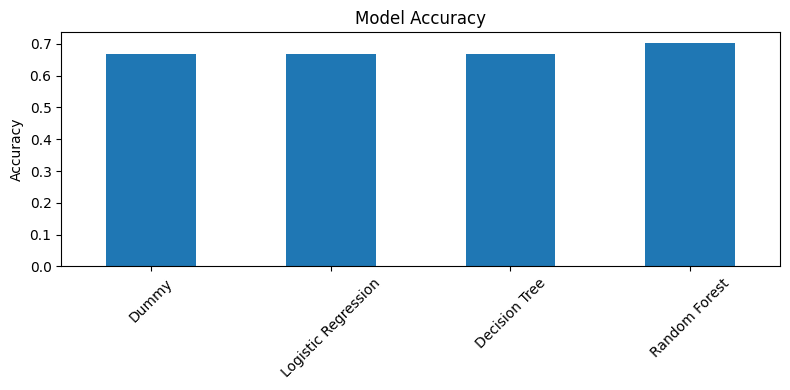

In [101]:
# Visualize accuracy
acc_df = pd.DataFrame({k: v["Accuracy"] for k, v in results.items()}, index=["Accuracy"]).T
acc_df.plot(kind="bar", legend=False, title="Model Accuracy", ylabel="Accuracy", figsize=(8, 4))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

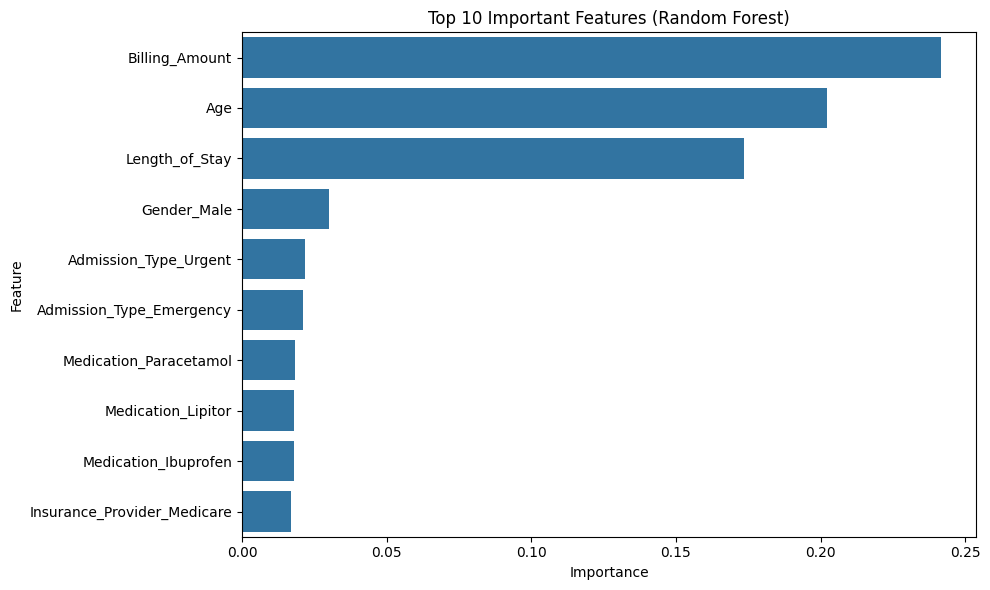

In [102]:
# Feature importance from Random Forest
importances = models["Random Forest"].feature_importances_
feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(10), x="Importance", y="Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

In [103]:
# Clean and prepare data
df_viz = df[['Test_Results', 'Billing_Amount', 'Length_of_Stay']].copy()

# Drop rows with missing or malformed values
df_viz = df_viz.dropna(subset=['Test_Results', 'Billing_Amount', 'Length_of_Stay'])

# Coerce numeric columns
df_viz['Billing_Amount'] = pd.to_numeric(df_viz['Billing_Amount'], errors='coerce')
df_viz['Length_of_Stay'] = pd.to_numeric(df_viz['Length_of_Stay'], errors='coerce')

# Drop rows with NaNs after coercion
df_viz = df_viz.dropna(subset=['Billing_Amount', 'Length_of_Stay'])

# Standardize test result labels
df_viz['Test_Results_Label'] = df_viz['Test_Results'].str.strip().str.lower().map({
    'normal': 'Normal',
    'abnormal': 'Abnormal',
    'inconclusive': 'Inconclusive'
})

# Drop rows with unmapped labels
df_viz = df_viz[df_viz['Test_Results_Label'].notna()]

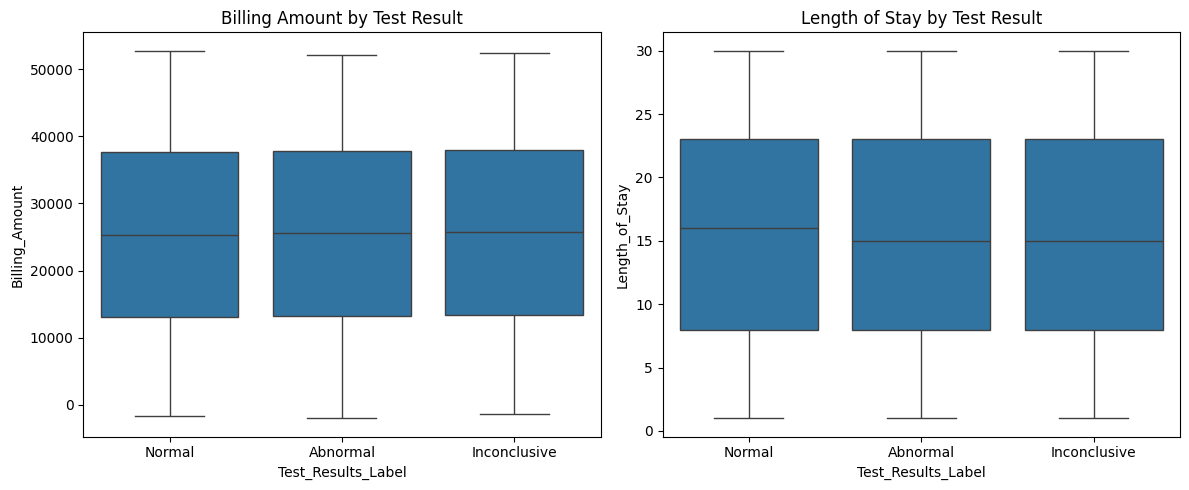

In [104]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_viz, x='Test_Results_Label', y='Billing_Amount', order=['Normal', 'Abnormal', 'Inconclusive'])
plt.title("Billing Amount by Test Result")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_viz, x='Test_Results_Label', y='Length_of_Stay', order=['Normal', 'Abnormal', 'Inconclusive'])
plt.title("Length of Stay by Test Result")

plt.tight_layout()
plt.show()

In [105]:
## Discussion and Impact

# **Predictive Power**: Random Forest outperformed other models, suggesting non-linear relationships in the data.
# **Key Drivers**: Age, Medical Condition, and Insurance Provider were top predictors of test outcomes.
# **Cost Trends**: Patients with positive test results had higher billing and longer stays, indicating greater resource use.
# **Hospital Planning**: These insights can guide staffing, bed allocation, and insurance negotiations.

## This analysis supports data-driven decision-making in healthcare operations and patient care optimization.